In [158]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
from itertools import product

# Initial Setup

In [197]:
# Load data
df = pd.read_csv('titik_semprotan.csv')
ids = df['id'].tolist()
locations = df[['x', 'y']].values

# --- 0) Caching jarak antar titik (tetap boleh dipakai on-demand) ---
distance_cache = {}

# id -> index ke array locations (diasumsikan locations selaras dengan ids)
id2idx = {i: k for k, i in enumerate(ids)}

def get_weight(i, j):
    key = (i, j)
    if key in distance_cache:
        return distance_cache[key]
    ii, jj = id2idx[i], id2idx[j]
    dx = locations[ii][0] - locations[jj][0]
    dy = locations[ii][1] - locations[jj][1]
    d = float(np.hypot(dx, dy))
    distance_cache[(i, j)] = d
    distance_cache[(j, i)] = d
    return d

# --- 1) Nodes deterministik (order-preserving unique), bukan set(ids) ---
nodes = list(dict.fromkeys(ids))     # menjaga urutan, menghilangkan duplikat
N = len(nodes)

# mapping ID -> index baris/kolom di D
idx = {node: k for k, node in enumerate(nodes)}

# --- 2) Bangun matrix koordinat sesuai urutan nodes ---
coords = np.empty((N, 2), dtype=np.float64)
for k, node in enumerate(nodes):
    ii = id2idx[node]
    coords[k, 0] = locations[ii][0]
    coords[k, 1] = locations[ii][1]

# --- 3) Vectorized distance matrix (cepat & konsisten) ---
diff = coords[:, None, :] - coords[None, :, :]     # shape (N, N, 2)
D = np.sqrt((diff * diff).sum(axis=2))              # shape (N, N), float64
np.fill_diagonal(D, 0.0)                            # diagonal nol

# Opsional: pakai matrix D + idx (lebih cepat, no cache lookup)
def total_distance(tour):
    L = len(tour)
    if L < 2:
        return 0.0
    s = 0.0
    for i in range(L - 1):
        s += D[idx[tour[i]], idx[tour[i+1]]]
    s += D[idx[tour[-1]], idx[tour[0]]]
    return float(s)

def split_ids(ids, num_vehicles):
    ids_copy = ids[:]
    random.shuffle(ids_copy)
    return [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

# K Clustering

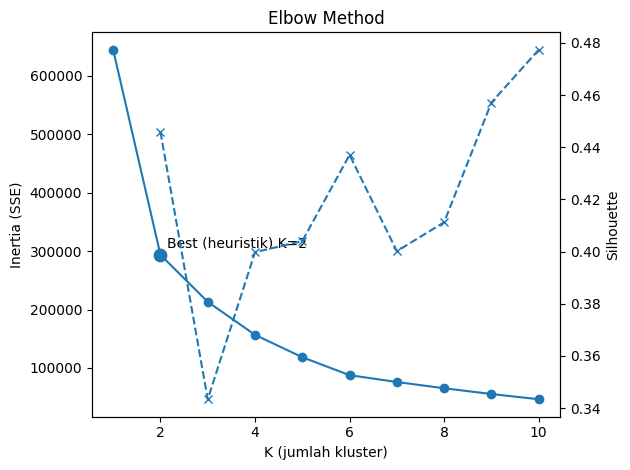

K kandidat: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Heuristik best K: 2
Jumlah kluster: 2
Cluster 0: 75 titik
Cluster 1: 60 titik


In [198]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow_analysis(coords, k_min=1, k_max=10, random_state=42, n_init=10, show_plot=True):
    k_values = list(range(k_min, min(k_max, len(coords)) + 1))
    inertias = []
    silhouettes = []

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(coords)
        inertias.append(km.inertia_)
        if k >= 2:
            sil = silhouette_score(coords, km.labels_)
            silhouettes.append(sil)
        else:
            silhouettes.append(np.nan)

    # Heuristik "knee" sederhana: cari K yang memaksimalkan penurunan relatif inertia
    # (bukan metode resmi kneedle, tapi praktis untuk start)
    best_k = k_values[0]
    if len(k_values) >= 3:
        drops = []
        for i in range(1, len(inertias)):
            drop = (inertias[i-1] - inertias[i]) / max(inertias[i-1], 1e-9)
            drops.append(drop)
        # Pilih K setelah penurunan terbesar (i index drop untuk transisi k_values[i-1] -> k_values[i])
        best_k = k_values[np.argmax(drops) + 1]

    if show_plot:
        fig, ax1 = plt.subplots()
        ax1.plot(k_values, inertias, marker='o')
        ax1.set_xlabel('K (jumlah kluster)')
        ax1.set_ylabel('Inertia (SSE)')
        ax1.set_title('Elbow Method')
        # Tandai best_k jika masuk dalam range
        if best_k in k_values:
            ybk = inertias[k_values.index(best_k)]
            ax1.scatter([best_k], [ybk], s=80)
            ax1.annotate(f'Best (heuristik) K={best_k}', (best_k, ybk), xytext=(5, 5), textcoords='offset points')

        # Plot silhouette di sumbu kedua (opsional)
        ax2 = ax1.twinx()
        ax2.plot(k_values, silhouettes, marker='x', linestyle='--')
        ax2.set_ylabel('Silhouette')

        plt.tight_layout()
        plt.show()

    return {
        "k_values": k_values,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k_heuristic": best_k
    }

def run_kmeans(coords, nodes, k, random_state=42, n_init=10):
    if k < 1 or k > len(coords):
        raise ValueError("k harus di antara 1 dan jumlah titik.")
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(coords)
    centroids = km.cluster_centers_

    clusters = {c: [] for c in range(k)}
    for node, lab in zip(nodes, labels):
        clusters[int(lab)].append(node)

    return labels, clusters, centroids

# === Contoh pemakaian cepat ===
# 1) Cari K yang masuk akal
info = elbow_analysis(coords, k_min=1, k_max=10, random_state=0, n_init=20, show_plot=True)
print("K kandidat:", info["k_values"])
print("Heuristik best K:", info["best_k_heuristic"])

# 2) Pilih K (misal dari heuristik atau manual), lalu cluster
chosen_k = info["best_k_heuristic"]
labels, clusters, centroids = run_kmeans(coords, nodes, chosen_k)
print("Jumlah kluster:", chosen_k)
for c, ids_in_c in clusters.items():
    print(f"Cluster {c}: {len(ids_in_c)} titik")

# === (Opsional) Visualisasi kluster ===
def plot_clusters(coords, labels, centroids=None):
    """
    Scatter plot titik dengan pewarnaan per kluster.
    """
    labels = np.asarray(labels)
    k = int(labels.max()) + 1
    for c in range(k):
        pts = coords[labels == c]
        plt.scatter(pts[:,0], pts[:,1], label=f'Cluster {c}', s=20)
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], marker='^', s=120)
    plt.legend()
    plt.title('K-Means Clusters')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

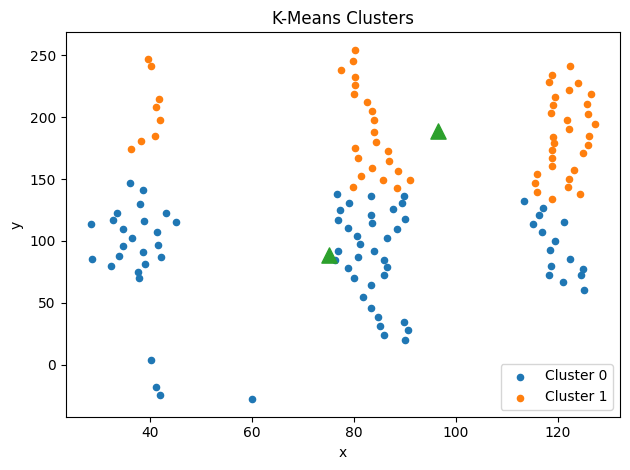

In [199]:
plot_clusters(coords, labels, centroids)

# Ortools for Benchmarking

In [162]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

SCALE = 1000  # presisi jarak

def _build_distance_matrix(nodes, use_D=True, scale=SCALE):
    N = len(nodes)
    if use_D:
        return [[int(round(scale * float(D[idx[nodes[i]], idx[nodes[j]]])))
                 for j in range(N)] for i in range(N)]
    else:
        return [[int(round(scale * get_weight(nodes[i], nodes[j])))
                 for j in range(N)] for i in range(N)]

def _remap_labels_to_vehicles(labels, starts_ids):
    """
    Pastikan indeks kendaraan 0..K-1 konsisten dengan urutan starts_ids.
    Kita buat mapping label_kluster -> vehicle_id berdasarkan label titik start tiap vehicle.
    """
    unique_from_starts = []
    for sid in starts_ids:
        unique_from_starts.append(labels[nodes.index(sid)])
    lbl_to_vid = {lbl: vid for vid, lbl in enumerate(unique_from_starts)}
    remapped = [lbl_to_vid[lbl] for lbl in labels]
    return remapped, lbl_to_vid

def create_data_model_clustered_custom(nodes, labels, starts_ids, ends_ids=None, scale=SCALE, use_D=True):
    """
    nodes: list ID node
    labels: label kluster (len == len(nodes)), sejajar dengan nodes
    starts_ids: list ID node start per vehicle (panjang K)
    ends_ids: list ID node end per vehicle (default = starts_ids)
    """
    assert len(nodes) == len(labels), "labels harus sejajar dengan nodes"
    K = len(starts_ids)
    if ends_ids is None:
        ends_ids = starts_ids[:]
    assert len(ends_ids) == K, "ends_ids harus sama panjang dengan starts_ids"

    # Remap label kluster -> vehicle index berdasar urutan starts
    labels_remap, lbl_to_vid = _remap_labels_to_vehicles(labels, starts_ids)

    # Validasi start/end ada di cluster/vehicle yang sesuai
    for v in range(K):
        sid = starts_ids[v]
        eid = ends_ids[v]
        assert sid in nodes and eid in nodes, "start/end harus ada di nodes"
        # Opsional: pastikan start/end berada di kluster kendaraan v (tidak wajib kalau kamu ingin fleksibel)
        # pass

    # Build distance matrix
    distance_matrix = _build_distance_matrix(nodes, use_D=use_D, scale=scale)

    # Allowed vehicles per node (node hanya boleh dilayani vehicle sesuai klusternya)
    node_allowed = {i: [int(labels_remap[i])] for i in range(len(nodes))}

    # Konversi starts/ends ke index internal (0..N-1)
    starts_idx = [nodes.index(x) for x in starts_ids]
    ends_idx   = [nodes.index(x) for x in ends_ids]

    return {
        "distance_matrix": distance_matrix,
        "num_vehicles": K,
        "starts": starts_idx,
        "ends": ends_idx,
        "node_allowed_vehicles": node_allowed,
        "nodes": nodes,
        "scale": scale,
    }

def _route_cost_from_matrix(route_node_indices, matrix):
    """Hitung cost (integer scaled) sepanjang rute (urutan node indices, termasuk akhir)."""
    cost = 0
    for a, b in zip(route_node_indices[:-1], route_node_indices[1:]):
        cost += matrix[a][b]
    return cost

def solve_vrp_clustered_custom(nodes, labels, starts_ids, ends_ids=None, timeout_s=60,
                               first_strategy="PATH_CHEAPEST_ARC",
                               metaheuristic="GUIDED_LOCAL_SEARCH",
                               use_D=True):
    data = create_data_model_clustered_custom(nodes, labels, starts_ids, ends_ids, use_D=use_D)

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['starts'],
                                           data['ends'])
    routing = pywrapcp.RoutingModel(manager)

    # Cost callback
    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return data['distance_matrix'][f][t]

    transit_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # Lock node -> vehicle sesuai kluster
    for node_id in range(len(nodes)):
        idx_index = manager.NodeToIndex(node_id)
        routing.SetAllowedVehiclesForIndex(data['node_allowed_vehicles'][node_id], idx_index)

    # Params pencarian
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = int(timeout_s)
    search_parameters.first_solution_strategy = getattr(
        routing_enums_pb2.FirstSolutionStrategy, first_strategy
    )
    search_parameters.local_search_metaheuristic = getattr(
        routing_enums_pb2.LocalSearchMetaheuristic, metaheuristic
    )

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print("No solution found!")
        return None, [], float('inf')

    # Ekstrak rute & biaya per-vehicle
    routes_ids = []
    per_vehicle_cost_float = []
    total_scaled = 0

    for v in range(data['num_vehicles']):
        index = routing.Start(v)
        route_idx = []
        while not routing.IsEnd(index):
            route_idx.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route_idx.append(manager.IndexToNode(index))  # tambahkan end

        # Konversi ke ID
        route_ids = [data['nodes'][i] for i in route_idx]
        routes_ids.append(route_ids)

        # Hitung cost rute ini langsung dari matrix (scaled)
        c_scaled = _route_cost_from_matrix(route_idx, data['distance_matrix'])
        total_scaled += c_scaled
        per_vehicle_cost_float.append(c_scaled / float(data['scale']))

    total_cost_float = total_scaled / float(data['scale'])
    return routes_ids, per_vehicle_cost_float, total_cost_float

def solve_vrp_clustered_random_starts(nodes, labels, timeout_s=60, use_D=True,
                                      seed=None, round_trip=True):
    """
    Pilih node start secara acak di tiap kluster, lalu solve VRP per-kluster.
    Mengembalikan:
      - starts: list start ID per vehicle/cluster
      - routes: list rute (list of node IDs) per vehicle
      - per_costs: biaya per vehicle (float, unscaled)
      - total_cost: total biaya (float, unscaled)
    """
    rng = random.Random(seed)
    K = int(max(labels)) + 1

    # kumpulkan node per kluster
    clusters = {c: [] for c in range(K)}
    for n, lab in zip(nodes, labels):
        clusters[int(lab)].append(n)

    # pilih start random per kluster
    starts_ids = [rng.choice(clusters[c]) for c in range(K)]

    # end: default round trip ke start; kalau mau random end juga, ubah di bawah
    if round_trip:
        ends_ids = starts_ids
    else:
        ends_ids = [rng.choice(clusters[c]) for c in range(K)]

    routes, per_costs, total_cost = solve_vrp_clustered_custom(
        nodes, labels, starts_ids, ends_ids,
        timeout_s=timeout_s, use_D=use_D
    )

    return {
        "starts": starts_ids,
        "routes": routes,
        "per_costs": per_costs,
        "total_cost": total_cost
    }

In [163]:
res = solve_vrp_clustered_random_starts(nodes, labels, timeout_s=20, use_D=True, seed=None)
print("Start per kluster:", res["starts"])
print("Biaya per kluster:", res["per_costs"])
print("Total cost:", res["total_cost"])
for i, r in enumerate(res["routes"], 1):
    print(f"Rute kendaraan {i}:", r)

Start per kluster: [72, 14]
Biaya per kluster: [743.453, 574.275]
Total cost: 1317.728
Rute kendaraan 1: [72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129, 67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 76, 85, 16, 60, 20, 88, 77, 69, 84, 8, 112, 96, 37, 81, 15, 93, 62, 132, 135, 53, 38, 78, 58, 18, 116, 41, 6, 108, 44, 128, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 106, 40, 72]
Rute kendaraan 2: [14, 134, 57, 73, 122, 28, 87, 121, 109, 68, 118, 19, 46, 45, 61, 126, 100, 33, 89, 131, 98, 48, 127, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 66, 2, 75, 119, 13, 102, 83, 31, 97, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 14]


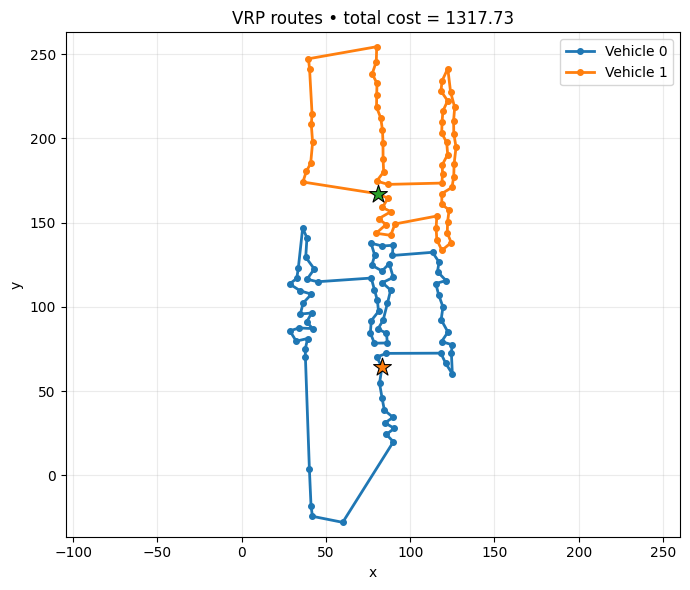

In [164]:
def _xy_of(node_id):
    # coords sejajar dengan `nodes`, dan `idx` memetakan id -> index
    return coords[idx[node_id], 0], coords[idx[node_id], 1]

def plot_routes_matplotlib(routes, starts=None, ends=None, show_ids=False, title="VRP routes"):
    fig, ax = plt.subplots(figsize=(7, 6))

    # plot semua titik sebagai background tipis
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.3, label="_all_points_bg")

    # gambar tiap rute
    for v, route in enumerate(routes):
        if len(route) == 0:
            continue

        # ambil koordinat sepanjang rute (termasuk node terakhir = end)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)

        # garis rutenya
        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Vehicle {v}")

        # tandai start & end
        s_id = starts[v] if starts is not None else route[0]
        e_id = ends[v]   if ends is not None   else route[-1]
        sx, sy = _xy_of(s_id)
        ex, ey = _xy_of(e_id)

        ax.scatter([sx],[sy], marker='*', s=180, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{v}")
        if e_id != s_id:
            ax.scatter([ex],[ey], marker='s', s=90, edgecolor='k', linewidths=0.8, zorder=5, label=f"_end_{v}")

        # optional: tulis ID di titik
        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_routes_matplotlib(
    routes=res["routes"],
    starts=res["starts"],
    ends=None,                # None -> otomatis dari list rute
    show_ids=False,
    title=f"VRP routes • total cost = {res['total_cost']:.2f}"
)

In [165]:
def plot_clustered_routes_matplotlib(cluster_routes, show_ids=False, title=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    # background semua titik
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.25, label="_all_points_bg")

    for c, route in enumerate(cluster_routes):
        if not route:
            continue

        # urutan titik termasuk menutup ke awal (jika L>=2)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)
        if len(route) >= 2:
            x0, y0 = _xy_of(route[0])
            xs.append(x0); ys.append(y0)

        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Cluster {c}")

        # tandai start (node pertama di list)
        sx, sy = _xy_of(route[0])
        ax.scatter([sx],[sy], marker='*', s=160, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{c}")

        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    if title is None:
        title = "Lovebird (clustered) routes"
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()